In [1]:
import os, sys
import numpy as np
import scipy.io as sio
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt

sys.path.append('..')
import face3d
import trimesh
from face3d import mesh
from face3d.morphable_model import MorphabelModel

In [2]:
def create_spherical_coords_grid(resolution=512):
    theta = np.linspace(0, np.pi, resolution)  # 0 to π
    phi = np.linspace(0, 2 * np.pi, resolution)  # 0 to 2π
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    return theta_grid, phi_grid

def calculate_radius(vertices, center_point):
    return np.linalg.norm(vertices - center_point, axis=1)


In [3]:
image_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.jpg'
mat_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.mat'
save_folder = 'single_results/posmap_300WLP_4995'

In [4]:
# uv_coords = face3d.morphable_model.load.load_uv_coords('Data/BFM/Out/BFM_UV.mat')
# uv_coords = process_uv(uv_coords, uv_h, uv_w)
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

In [5]:
info = sio.loadmat(mat_path)
shape_para = info['Shape_Para'].astype(np.float32)
exp_para = info['Exp_Para'].astype(np.float32)
vertices = bfm.generate_vertices(shape_para, exp_para)

In [6]:
faces = bfm.full_triangles

# Create a trimesh mesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

if not mesh.is_volume:
    print("Warning: The mesh is not a valid volume. This might affect proximity queries.")

In [7]:
mesh.show()

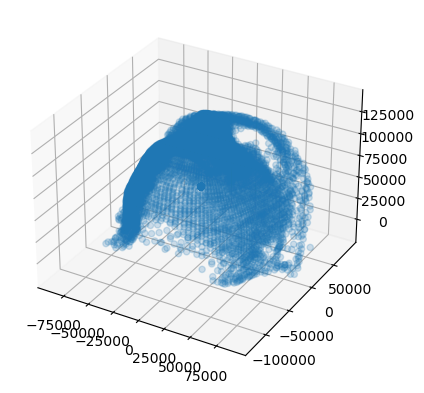

In [240]:
point_cloud = trimesh.points.PointCloud(points_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], color='pink', alpha=0.3)
ax.scatter(point_cloud.vertices[:, 0], point_cloud.vertices[:, 1], point_cloud.vertices[:, 2], s=1, alpha=0.2)
plt.show()

In [402]:
# Replace with the path to your BFM model file
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

# Example parameters (replace with actual data or parameters from your model)
shape_para = np.random.rand(bfm.n_shape_para, 1)  # Example shape parameters
exp_para = np.random.rand(bfm.n_exp_para, 1)      # Example expression parameters

# Generate vertices of the 3D face model
vertices = bfm.generate_vertices(shape_para, exp_para)

# Find the geometric center of the model
face_center = np.mean(vertices, axis=0)

In [403]:
def cartesian_to_spherical(coords, center):
    x, y, z = coords - center
    radius = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)  # Inclination
    phi = np.arctan2(y, x)                      # Azimuth
    return phi, theta, radius

# Convert each vertex to spherical coordinates
spherical_coords = np.array([cartesian_to_spherical(v, face_center) for v in vertices])


In [417]:
# Define the resolution of your 2D map
res_phi, res_theta = 1024, 1024  # Adjust as needed
radius_map = np.zeros((res_theta, res_phi))

# Populate the radius map
for phi, theta, radius in spherical_coords:
    # Convert spherical coordinates to 2D map indices
    i = int(((phi + np.pi) / (2 * np.pi)) * (res_phi - 1))
    j = int((theta / np.pi) * (res_theta - 1))

    radius_map[j, i] = radius

# Normalize the radius map for visualization
radius_map_normalized = (radius_map - np.min(radius_map)) / (np.max(radius_map) - np.min(radius_map))


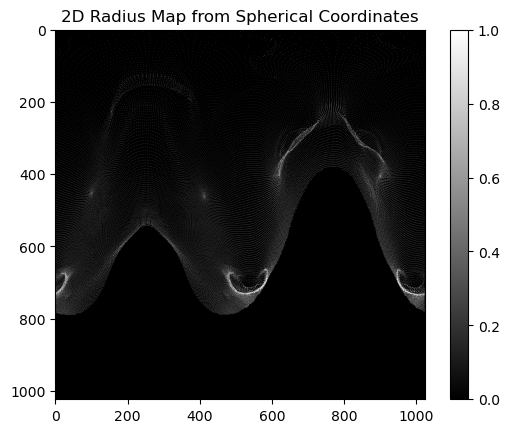

In [418]:
plt.imshow(radius_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radius Map from Spherical Coordinates")
plt.show()


In [419]:
def spherical_to_cartesian(phi, theta, radius):
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return np.array([x, y, z])

# Initialize an array to hold the reconstructed 3D points
reconstructed_vertices = []

# Iterate through the 2D radius map
for i in range(res_phi):
    for j in range(res_theta):
        # Convert the 2D indices back to spherical coordinates (phi, theta)
        phi = (i / (res_phi - 1)) * 2 * np.pi - np.pi
        theta = (j / (res_theta - 1)) * np.pi

        # Retrieve the radius from the map
        radius = radius_map[j, i]

        # Convert back to Cartesian coordinates
        if radius > 0:  # Skip points with zero radius
            vertex = spherical_to_cartesian(phi, theta, radius)
            reconstructed_vertices.append(vertex)

reconstructed_vertices = np.array(reconstructed_vertices)

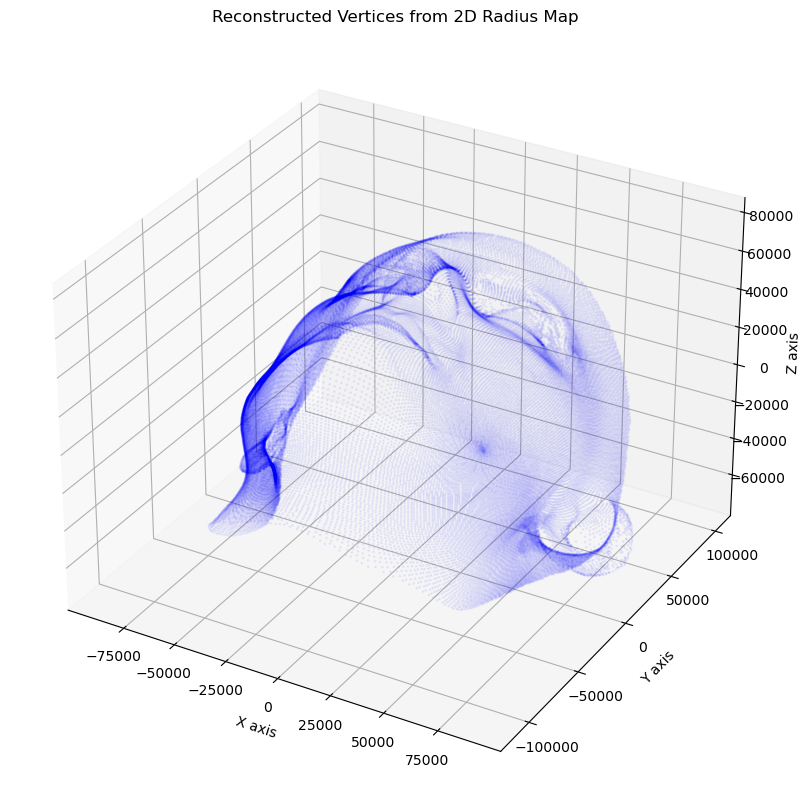

In [420]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the reconstructed vertices
ax.scatter(reconstructed_vertices[:, 0], reconstructed_vertices[:, 1], reconstructed_vertices[:, 2], color="blue", s=1, alpha=0.05)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title("Reconstructed Vertices from 2D Radius Map")
plt.show()

In [442]:
# Replace with the path to your BFM model file
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

# Example parameters (replace with actual data or parameters from your model)
shape_para = np.random.rand(bfm.n_shape_para, 1)  # Example shape parameters
exp_para = np.random.rand(bfm.n_exp_para, 1)      # Example expression parameters

# Generate vertices of the 3D face model
vertices = bfm.generate_vertices(shape_para, exp_para)

In [443]:
z_offset = -15000
center_x, center_z = face_center[0], face_center[2] + z_offset

def cartesian_to_cylindrical_vertical_axis(vertex):
    x, z, y = vertex[0] - center_x, vertex[2] - center_z, vertex[1]
    r = np.sqrt(x**2 + z**2)
    phi = np.arctan2(x, z)  # Measure angle from positive z-axis towards x-axis
    return r, phi, y

most_negative_phi = np.pi  # Start with the highest positive value
most_positive_phi = -np.pi  # Start with the lowest negative value
leftmost_vertex = None
rightmost_vertex = None

# Convert each vertex to cylindrical coordinates and find the leftmost and rightmost points
for v in vertices:
    r, phi, y = cartesian_to_cylindrical_vertical_axis(v)
    if phi < most_negative_phi:
        most_negative_phi = phi
        leftmost_vertex = v
        # print(v)
    if phi > most_positive_phi:
        most_positive_phi = phi
        rightmost_vertex = v
        # print(v)

cylindrical_coords = np.array([cartesian_to_cylindrical_vertical_axis(v) for v in vertices])


In [483]:
z_offset = -15000
center_x, center_z = face_center[0], face_center[2] + z_offset

def cartesian_to_cylindrical_vertical_axis(vertex):
    x, z, y = vertex[0] - center_x, vertex[2] - center_z, vertex[1]
    r = np.sqrt(x**2 + z**2)
    phi = np.arctan2(x, z)  # Measure angle from positive z-axis towards x-axis
    return r, phi, y

most_negative_phi = -np.pi/2
most_positive_phi = np.pi/2
# leftmost_vertex = None
# rightmost_vertex = None

# Convert each vertex to cylindrical coordinates and save to array
cylindrical_coords = []
for v in vertices:
    r, phi, y = cartesian_to_cylindrical_vertical_axis(v)
    if most_negative_phi <= phi <= most_positive_phi:
        cylindrical_coords.append((r, phi, y))
cylindrical_coords = np.array(cylindrical_coords)
        
# cylindrical_coords = np.array([cartesian_to_cylindrical_vertical_axis(v) for v in vertices])


In [474]:
print(cartesian_to_cylindrical_vertical_axis(leftmost_vertex))

(79601.35287453744, -2.3428744806281285, -39225.93780057975)


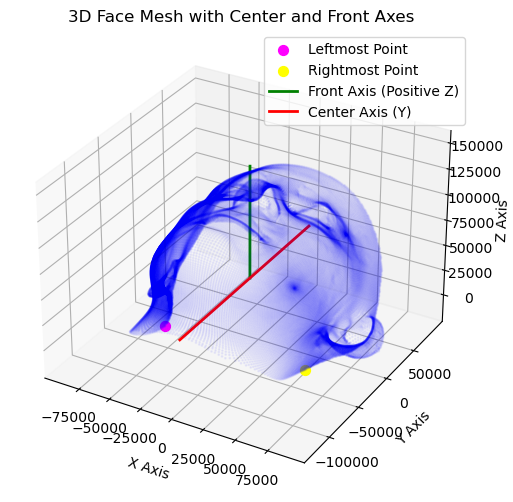

In [484]:
x, y, z = vertices[:,0], vertices[:,1], vertices[:,2]
center_x, center_y, center_z = face_center[0], face_center[1], face_center[2] + z_offset

left_x, left_y, left_z = leftmost_vertex[0], leftmost_vertex[1], leftmost_vertex[2]
right_x, right_y, right_z = rightmost_vertex[0], rightmost_vertex[1], rightmost_vertex[2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='blue', s=1, alpha=0.05)

# Highlight the leftmost and rightmost points
ax.scatter(left_x, left_y, left_z, color='magenta', s=50, label='Leftmost Point')
ax.scatter(right_x, right_y, right_z, color='yellow', s=50, label='Rightmost Point')

# Plot the front-facing axis (positive z-axis)
z_front_min, z_front_max = center_z, 150000
ax.plot([center_x, center_x], [center_y, center_y], [z_front_min, z_front_max], color='green', linewidth=2, label='Front Axis (Positive Z)')

# Plot the center axis
ax.plot([center_x, center_x], [np.min(y), np.max(y)], [center_z, center_z], color='red', linewidth=2, label='Center Axis (Y)')

# Set labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Face Mesh with Center and Front Axes')
ax.legend()

plt.show()

In [508]:
res_phi, res_y = 512, 512  # Resolution of the cylindrical map
radial_map = np.zeros((res_y, res_phi))

In [509]:
# Calculate the range of phi
phi_range = most_positive_phi - most_negative_phi

# Populate the radial map
for r, phi, y in cylindrical_coords:
    # Normalize the azimuthal angle to the range [0, 1]
    phi_normalized = (phi - most_negative_phi) / phi_range

    # Convert normalized azimuthal angle to 2D map indices
    i = int(phi_normalized * (res_phi - 1))
    j = res_y - 1 - int((y - np.min(vertices[:,1])) / (np.max(vertices[:,1]) - np.min(vertices[:,1])) * (res_y - 1))

    radial_map[j, i] = r

# Normalize the radial map for visualization
radial_map_normalized = (radial_map - np.min(radial_map)) / (np.max(radial_map) - np.min(radial_map))


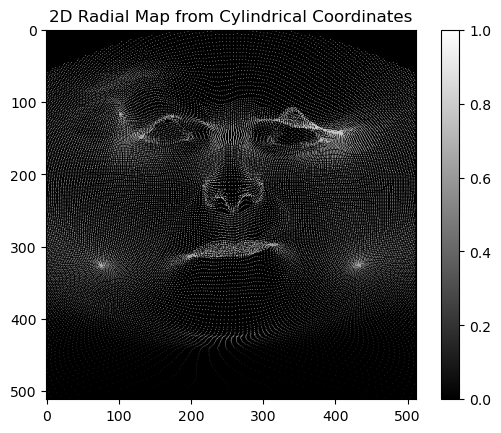

In [510]:
plt.imshow(radial_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [511]:
from scipy.interpolate import griddata
import numpy as np

# Assuming radial_map is the initial map with potential gaps
# Create a grid of coordinates representing each cell in the map
y_coords, phi_coords = np.mgrid[0:res_y, 0:res_phi]

# Create arrays of known values and their corresponding coordinates
known_values = radial_map_normalized[radial_map_normalized != 0]  # Filter out cells with value 0 (assuming these are the gaps)
known_coords = np.array([(j, i) for j in range(res_y) for i in range(res_phi) if radial_map_normalized[j, i] != 0])

# Perform grid interpolation to fill the gaps
interpolated_map = griddata(known_coords, known_values, (y_coords, phi_coords), method='linear')

# Replace NaN values with zeros (if any) after interpolation
interpolated_map = np.nan_to_num(interpolated_map)

# Normalize the interpolated map for visualization
interpolated_map_normalized = (interpolated_map - np.min(interpolated_map)) / (np.max(interpolated_map) - np.min(interpolated_map))

In [523]:
# Define the resolution in y and φ (angle) directions
res_y, res_phi = radial_map_normalized.shape

# Create a grid of coordinates representing each cell in the map
y_coords, phi_coords = np.mgrid[0:res_y, 0:res_phi]

# Create arrays of known values and their corresponding coordinates
# Filter out cells with value 0 (assuming these are the gaps)
known_values = radial_map_normalized[radial_map_normalized != 0]
known_coords = np.array([(j, i) for j in range(res_y) for i in range(res_phi) if radial_map_normalized[j, i] != 0])

# Perform grid interpolation to fill the gaps
# Use 'linear' or 'cubic' for smoother results as needed
interpolated_map = griddata(known_coords, known_values, (y_coords, phi_coords), method='linear')

# Replace NaN values with zeros (if any) after interpolation
interpolated_map = np.nan_to_num(interpolated_map)

# Normalize the interpolated map for visualization
interpolated_map_normalized = (interpolated_map - np.min(interpolated_map)) / (np.max(interpolated_map) - np.min(interpolated_map))

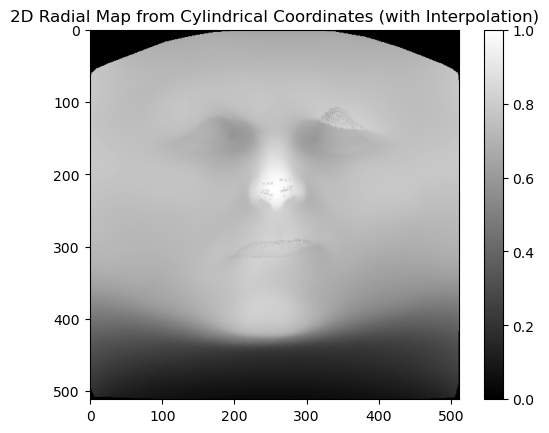

In [524]:
plt.imshow(interpolated_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates (with Interpolation)")
plt.show()

In [513]:
# Initialize an array to hold the reconstructed vertices
reconstructed_vertices = []

# Iterate over the 2D map
for j in range(res_y):
    for i in range(res_phi):
        # Retrieve the radius value from the interpolated map
        r = radial_map_normalized[j, i]

        # Skip points where the radius is zero
        if r == 0:
            continue

        # Reverse the normalization of the azimuthal angle and y-coordinate
        phi = (i / (res_phi - 1)) * phi_range + most_negative_phi
        y = np.max(vertices[:,1]) - (j / (res_y - 1)) * (np.max(vertices[:,1]) - np.min(vertices[:,1]))

        # Convert back to Cartesian coordinates
        x = r * np.sin(phi) + center_x
        z = r * np.cos(phi) + center_z - z_offset
        reconstructed_vertices.append([x, y, z])

reconstructed_vertices = np.array(reconstructed_vertices)


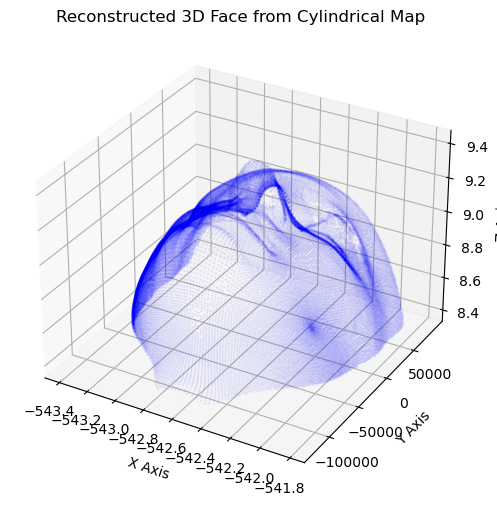

In [514]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_vertices[:,0], reconstructed_vertices[:,1], reconstructed_vertices[:,2], color='blue', s=1, alpha=0.05)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map')

plt.show()


In [515]:
# Initialize an array to hold the reconstructed vertices
reconstructed_vertices_interpolated = []

# Iterate over the 2D map
for j in range(res_y):
    for i in range(res_phi):
        # Retrieve the radius value from the interpolated map
        r = interpolated_map_normalized[j, i]

        # Skip points where the radius is zero
        if r == 0:
            continue

        # Reverse the normalization of the azimuthal angle and y-coordinate
        phi = (i / (res_phi - 1)) * phi_range + most_negative_phi
        y = np.max(vertices[:,1]) - (j / (res_y - 1)) * (np.max(vertices[:,1]) - np.min(vertices[:,1]))

        # Convert back to Cartesian coordinates
        x = r * np.sin(phi) + center_x
        z = r * np.cos(phi) + center_z - z_offset
        reconstructed_vertices_interpolated.append([x, y, z])

reconstructed_vertices_interpolated = np.array(reconstructed_vertices_interpolated)

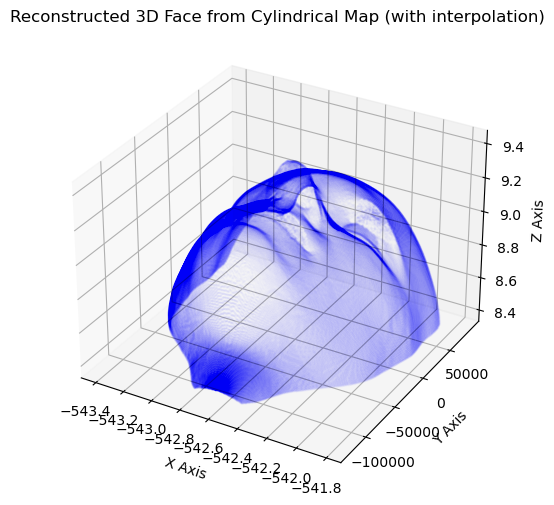

In [518]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_vertices_interpolated[:,0], reconstructed_vertices_interpolated[:,1], reconstructed_vertices_interpolated[:,2], color='blue', s=1, alpha=0.01)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map (with interpolation)')

plt.show()